In [1]:
from const import *
from function import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
import itertools

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from tqdm import tqdm
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from catboost import Pool

warnings.simplefilter('ignore')

In [2]:
data_path = '../1.data/'
train_file_name = 'train.csv'
test_file_name  = 'test.csv'

In [3]:
train_df = pd.read_csv(f'{data_path}{train_file_name}')
test_df = pd.read_csv(f'{data_path}{test_file_name}')
master_df = creansing_dataset(pd.concat([train_df, test_df]))

In [4]:
non_cols = ['id', 'price']
num_cols = ['year', 'odometer']
cat_cols = [col for col in train_df.columns if col not in non_cols + num_cols]

In [5]:
master_df = create_features_main(master_df, cat_cols)
train_df = master_df[~master_df['price'].isnull()].reset_index(drop=True).copy()
test_df  = master_df[master_df['price'].isnull()].copy()

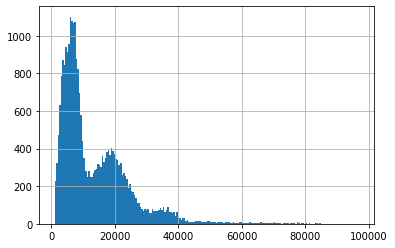

In [6]:
train_df['price'].hist(bins=200)

price_threshhold = 12000
train_df.loc[train_df['price'] <= price_threshhold, 'c_price'] = 0
train_df.loc[train_df['price'] >= price_threshhold, 'c_price'] = 1

In [7]:
input_cols = train_df.drop(['price', 'id', 'c_price'], axis=1).columns
target = 'c_price'
cv = 5
model_type = 'Classification'

models, preds, scores, importnace_l = \
        train_model(
            train_df, 
            target, 
            cv, 
            model_type, 
            cat_cols,
            input_cols)

0:	learn: 0.6457423	test: 0.6478380	best: 0.6478380 (0)	total: 209ms	remaining: 1m 44s
100:	learn: 0.3832920	test: 0.4129298	best: 0.4129298 (100)	total: 8.74s	remaining: 34.5s
200:	learn: 0.3604758	test: 0.4065401	best: 0.4064521 (199)	total: 18.3s	remaining: 27.2s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.405783914
bestIteration = 233

Shrink model to first 234 iterations.
0:	learn: 0.6384695	test: 0.6387633	best: 0.6387633 (0)	total: 80.2ms	remaining: 40s
100:	learn: 0.3877314	test: 0.3986143	best: 0.3986143 (100)	total: 8.73s	remaining: 34.5s
200:	learn: 0.3661209	test: 0.3944016	best: 0.3940968 (191)	total: 17.4s	remaining: 25.9s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.3940967539
bestIteration = 191

Shrink model to first 192 iterations.
0:	learn: 0.6416557	test: 0.6413020	best: 0.6413020 (0)	total: 111ms	remaining: 55.3s
100:	learn: 0.3824878	test: 0.4077568	best: 0.4077568 (100)	total: 12s	remaining: 47.3s
200:	learn: 0.36004

In [8]:
calc_confusion_matricx(preds, cv)

f1 score = 0.7677170589017417


,Negative_Predict,Positive_Predict
Negative_Actual,13630,2212
Positive_Actual,3029,8661


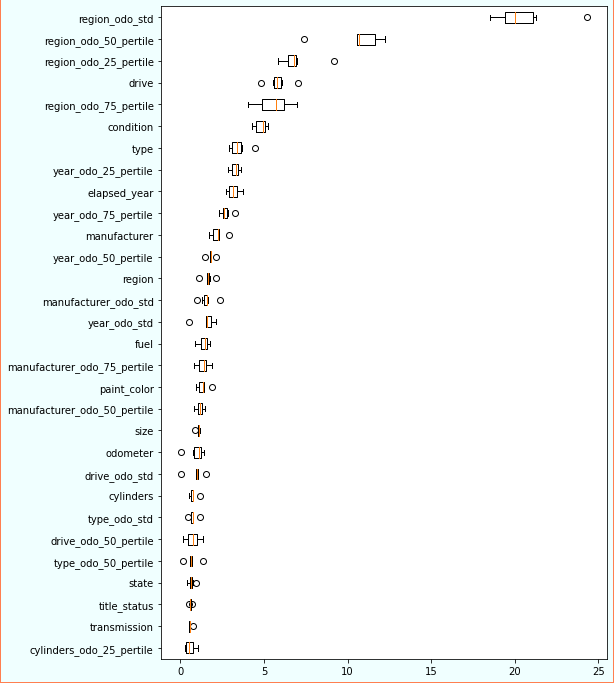

In [9]:
plot_importance(importnace_l, input_cols, 30)

In [10]:
test_df = add_c_price(test_df, cv, input_cols, models)
c_price_df = pd.concat([
    train_df[['id', 'c_price']], 
    test_df[['id', 'c_price']]
])

train_df = pd.read_csv(f'{data_path}{train_file_name}')
test_df = pd.read_csv(f'{data_path}{test_file_name}')
master_df = creansing_dataset(pd.concat([train_df, test_df]))
master_df = pd.merge(
    left = master_df,
    right = c_price_df,
    on = 'id', how='left'
)

master_df.head()

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price,c_price
0,0,nashville,1949,bmw,excellent,6 cylinders,gas,115148.0,clean,manual,rwd,mid-size,convertible,orange,NaN,27587.0,1.0
1,1,state college,2013,toyota,fair,8 cylinders,gas,172038.0,clean,automatic,rwd,full-size,sedan,silver,pa,4724.0,0.0
2,2,wichita,1998,ford,good,6 cylinders,gas,152492.0,clean,automatic,fwd,full-size,SUV,silver,ks,10931.0,0.0
3,3,albany,2014,ford,excellent,4 cylinders,gas,104118.0,clean,manual,fwd,mid-size,SUV,blue,ny,16553.0,1.0
4,4,redding,2005,ford,excellent,6 cylinders,gas,144554.0,clean,manual,fwd,mid-size,sedan,red,ca,5158.0,0.0


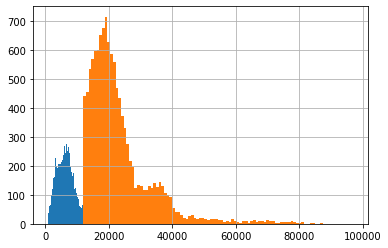

In [11]:
train_df_d = {}
test_df_d = {}
for c_price, grp_master in master_df.groupby('c_price'):
    grp_master = create_features_main(grp_master, cat_cols)
    train_df_d[c_price] = grp_master[~grp_master['price'].isnull()]
    test_df_d[c_price] = grp_master[grp_master['price'].isnull()]

    grp_master[~grp_master['price'].isnull()]['price'].hist(bins=100)

In [12]:
c_price = 0
train_df = train_df_d[c_price]
input_cols = train_df.drop(['price', 'id', 'c_price'], axis=1).columns
target = 'price'
cv = 3
model_type = 'Regression'

models, preds, scores, importnace_l = \
        train_model(
            train_df, 
            target, 
            cv, 
            model_type, 
            cat_cols,
            input_cols)

0:	learn: 0.4210047	test: 0.4205939	best: 0.4205939 (0)	total: 60.9ms	remaining: 30.4s
100:	learn: 0.3756835	test: 0.3794767	best: 0.3794767 (100)	total: 6.8s	remaining: 26.9s
200:	learn: 0.3634121	test: 0.3688403	best: 0.3688403 (200)	total: 13.6s	remaining: 20.3s
300:	learn: 0.3598789	test: 0.3664793	best: 0.3663060 (293)	total: 20.9s	remaining: 13.8s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.3663060342
bestIteration = 293

Shrink model to first 294 iterations.
0:	learn: 0.4213913	test: 0.4257015	best: 0.4257015 (0)	total: 65.8ms	remaining: 32.8s
100:	learn: 0.3840453	test: 0.3924713	best: 0.3924713 (100)	total: 6.73s	remaining: 26.6s
200:	learn: 0.3727477	test: 0.3832156	best: 0.3832156 (200)	total: 13.6s	remaining: 20.2s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.3794218992
bestIteration = 276

Shrink model to first 277 iterations.
0:	learn: 0.4234995	test: 0.4196211	best: 0.4196211 (0)	total: 94.2ms	remaining: 47s
100:	learn: 0.38

In [13]:
def plot_result(preds, cv):
    pred_df_l = []
    for i in range(cv):
        pred_df_l.append(
            pd.DataFrame(np.array(preds[i]).T, columns=["id", "actual", "pred"])
        )

    pred_df = pd.concat(pred_df_l)

    plt.figure(figsize=(8, 5), facecolor="azure", edgecolor="coral", linewidth=2)
    bins = np.linspace(0, pred_df["actual"].max(), 200)
    plt.hist(pred_df["actual"], bins, alpha=0.5, label="actual")
    plt.hist(pred_df["pred"], bins, alpha=0.5, label="b")

    fig = plt.figure(figsize=(5, 5), facecolor="azure", edgecolor="coral", linewidth=2)
    ax1 = fig.add_subplot()
    ax1.set_ylim([0, pred_df["actual"].max()])
    ax1.set_xlim([0, pred_df["actual"].max()])
    ax1.scatter(pred_df["actual"], pred_df["pred"])

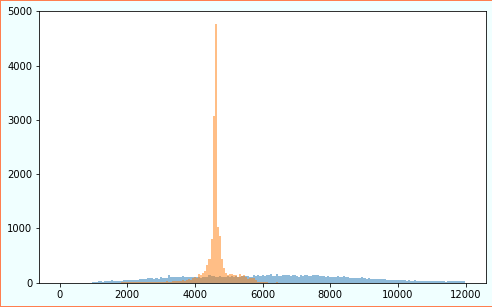

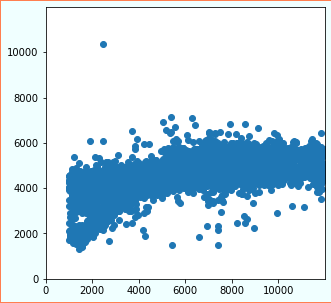

In [14]:
plot_result(preds, cv)

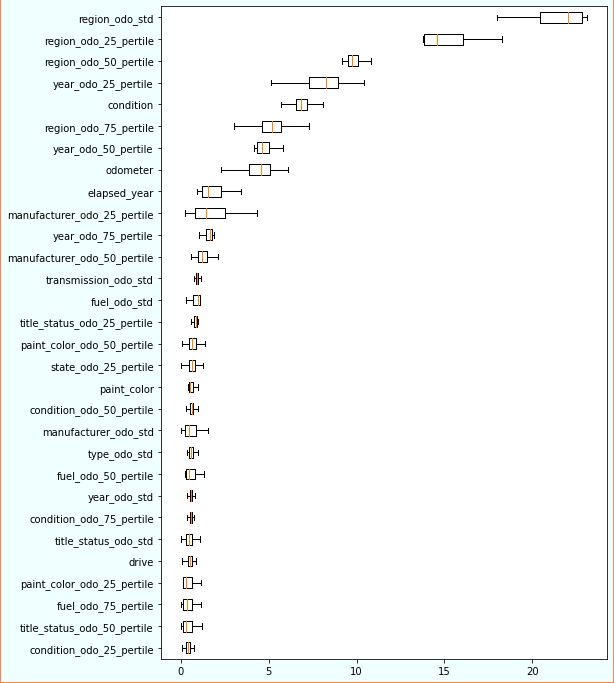

In [15]:
plot_importance(importnace_l, input_cols, 30)

In [16]:
# from datetime import datetime
# output_name = str(datetime.now().strftime('%Y%m%d %H:%M:%S')).replace('-','').replace(':','')

# submit_df = pd.read_csv(f'{data_path}submit_sample.csv', header=None)
# for fold in range(cv):
#     submit_df[f'fold{fold}'] = np.exp(models[fold].predict(test_df[input_cols]))


# submit_df['mean'] = submit_df[[f'fold{i}' for i in range(cv)]].mean(axis=1)
# # submit_df[[0, 'mean']].to_csv(f'../3.hist/{output_name}.csv', index=False, header=None)